# Double Machine Learning Simplified

## Part 1: Basic Causal Inference Applications

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from stargazer.stargazer import Stargazer
import graphviz

### Example 1

#### DAG

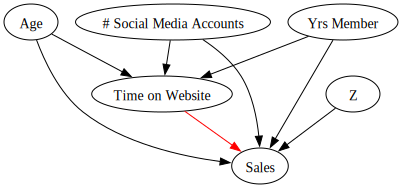

In [2]:
# Create a directed graph
g_1 = graphviz.Digraph(format='png')

# Add nodes
nodes_1 = ['Age', '# Social Media Accounts', 'Yrs Member', 'Time on Website', 'Sales', 'Z']
[g_1.node(n) for n in nodes_1]

g_1.edge('Age','Time on Website')
g_1.edge('# Social Media Accounts','Time on Website')
g_1.edge('Yrs Member','Time on Website')
g_1.edge('Age','Sales')
g_1.edge('# Social Media Accounts','Sales')
g_1.edge('Yrs Member','Sales')
g_1.edge('Time on Website','Sales',color='red')
g_1.edge('Z','Sales')
# g_1.edges(['AX', 'XB', 'AY', 'YB'])

# g_1.graph_attr['dpi'] = '400'

# Render for print
# g_1.render('dags/dag1')

g_1

#### Data Generating Process

In [3]:
N = 100_000

# Confounders
age = np.random.randint(low=18,high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)

# Covariates
X = np.random.normal(loc=50, scale = 25, size = N)

# Error Terms
ε1 = np.random.normal(loc=20,scale=5,size=N)
ε2 = np.random.normal(loc=40,scale=15,size=N)

# Treatment (T)
time_on_website = np.maximum( np.random.normal(loc=10, scale=5, size=N) 
                             - 0.01*age 
                             - 0.001*age**2 
                             + num_social_media_profiles 
                             - 0.01 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 0.2 * yr_membership
                             + 0.001 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 0.2 * (num_social_media_profiles * yr_membership)
                             + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + ε1
                               ,0)

# Outcome (y)
sales = np.maximum( np.random.normal(loc=25, scale=10, size=N)
                             +  5 * time_on_website # Simulated ATE = 5
                             - 0.1*age 
                             - 0.001*age**2 
                             + 8 * num_social_media_profiles 
                             - 0.1 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 2 * yr_membership
                             + 0.1 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 3 * (num_social_media_profiles * yr_membership)
                             + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + 0.5 * X
                             + ε2
                               ,0)

collider = np.random.normal(loc=100, scale=50, size=N) + 2*sales + 7*time_on_website

df = pd.DataFrame(np.array([sales,time_on_website,age,num_social_media_profiles,yr_membership,X, collider]).T
                  ,columns=["sales","time_on_website","age","num_social_media_profiles","yr_membership","X","collider"])

#### Models

In [6]:
naive_regression = smf.ols(formula='sales ~ 1 + time_on_website',data=df).fit()
print(naive_regression.summary())

multiple_regression = smf.ols(formula='sales ~ 1 + time_on_website + age + num_social_media_profiles + yr_membership',data=df).fit()
print(multiple_regression.summary())

# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

DML_model = smf.ols(formula='residualized_sales ~ 1 + residualized_time_on_website', data = df).fit()
print(DML_model.summary())


# DML Procedure w/ Collider
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership","collider"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership", "collider"]], df['time_on_website'], cv=3)

df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

DML_model_collider = smf.ols(formula='residualized_sales ~ 1 + residualized_time_on_website', data = df).fit()
print(DML_model_collider.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.728e+06
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:24:23   Log-Likelihood:            -5.8892e+05
No. Observations:              100000   AIC:                         1.178e+06
Df Residuals:                   99998   BIC:                         1.178e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -170.2382      0.677   -2

#### Write Table

In [223]:
# file = open('Example 1.html','w')

# order = ['time_on_website','residualized_time_on_website','age','num_social_media_profiles','yr_membership','Intercept']
# rename = {'time_on_website':'Treatment: Hours on Website','residualized_time_on_website':'Residualized Treatment: Hours on Website','age':'Age',
#           'num_social_media_profiles':"# of Social Media Profiles", "yr_membership":"Years of Membership"}
# columns = ['Naive OLS','Multiple OLS','DML','DML w/ Collider']

# regtable = Stargazer([naive_regression, multiple_regression, DML_model, DML_model_collider])
# regtable.covariate_order(order)
# regtable.custom_columns(columns,[1,1,1,1])
# regtable.rename_covariates(rename)
# regtable.show_degrees_of_freedom(False)
# regtable.title('Example 1: Obtaining Exogeneity w/ DML')

# file.write(regtable.render_html())
# file.close()

### Example 2

#### DAG

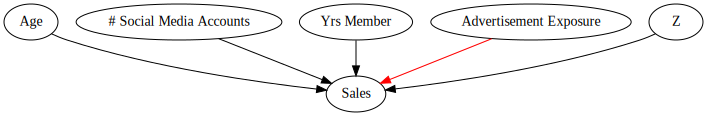

In [7]:
# Create a directed graph
g_2 = graphviz.Digraph(format='png')

# Add nodes
nodes_2 = ['Age', '# Social Media Accounts', 'Yrs Member', 'Advertisement Exposure', 'Sales', 'Z']
[g_2.node(n) for n in nodes_2]

g_2.edge('Age','Sales')
g_2.edge('# Social Media Accounts','Sales')
g_2.edge('Yrs Member','Sales')
g_2.edge('Z','Sales')
g_2.edge('Advertisement Exposure','Sales',color='red')

# g_2.graph_attr['dpi'] = '400'

# Render for print
# g_2.render('dags/dag2')

g_2

#### Data Generating Process

In [4]:
N = 100_000

# Covariates (X)
age = np.random.randint(low=18,high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
X = np.random.normal(loc=50, scale = 25, size = N)

# Error Term
ε = np.random.normal(loc=40,scale=15,size=N)

# Randomized Treatment (T)
advertisement_exposure = np.random.choice([0,1],size=N,p=[.5,.5])

# Outcome (y)
sales = np.maximum( np.random.normal(loc=500, scale=25, size=N)
                             +  5 * advertisement_exposure
                             - 10*age 
                             - 0.05*age**2 
                             + 15 * num_social_media_profiles 
                             - 0.01 * num_social_media_profiles**2
                             - 0.5*(age * num_social_media_profiles)
                             + 20 * yr_membership
                             + 0.5 * yr_membership**2
                             - 0.8 * (age * yr_membership)
                             + 5 * (num_social_media_profiles * yr_membership)
                             + 0.8 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + 15 * X
                             + 2 * X**2
                             + ε
                               ,0)


df = pd.DataFrame(np.array([sales,advertisement_exposure,age,num_social_media_profiles,yr_membership, X]).T,columns=["sales","advertisement_exposure","age","num_social_media_profiles","yr_membership","X"])

#### Models

In [6]:
naive_regression = smf.ols(formula='sales ~ 1 + advertisement_exposure',data=df).fit()
print(naive_regression.summary())

multiple_regression = smf.ols(formula='sales ~ 1 + advertisement_exposure + age + num_social_media_profiles + yr_membership + X',data=df).fit()
print(multiple_regression.summary())

# DML Procedure
M_sales = GradientBoostingRegressor()
M_advertisement_exposure = GradientBoostingClassifier()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership","X"]], df['sales'], cv=3)
residualized_advertisement_exposure = df['advertisement_exposure'] - cross_val_predict(M_advertisement_exposure, df[["age","num_social_media_profiles","yr_membership", "X"]], df['advertisement_exposure'], cv=3, method = 'predict_proba')[:,1]

df['residualized_sales'] = residualized_sales
df['residualized_advertisement_exposure'] = residualized_advertisement_exposure

DML_model = smf.ols(formula='residualized_sales ~ 1 + residualized_advertisement_exposure', data = df).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.218
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.270
Time:                        22:55:59   Log-Likelihood:            -1.0088e+06
No. Observations:              100000   AIC:                         2.018e+06
Df Residuals:                   99998   BIC:                         2.018e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8471

#### Write Table

In [239]:
# file = open('Example 2.html','w')

# order = ['advertisement_exposure','residualized_advertisement_exposure','age','num_social_media_profiles','yr_membership','Intercept']
# rename = {'advertisement_exposure':'Treatment: Exposure to Advertisement','residualized_advertisement_exposure':'Residualized Treatment: Exposure to Advertisement','age':'Age',
#           'num_social_media_profiles':"# of Social Media Profiles", "yr_membership":"Years of Membership"}
# columns = ['Naive OLS','Multiple OLS','DML']

# regtable = Stargazer([naive_regression, multiple_regression, DML_model])
# regtable.covariate_order(order)
# regtable.custom_columns(columns,[1,1,1])
# regtable.rename_covariates(rename)
# regtable.show_degrees_of_freedom(False)
# regtable.title('Example 2: Improving Statistical Power in RCT')

# file.write(regtable.render_html())
# file.close()